In [8]:
# ## Step 1: Set up the Environment and Define Constants
#
# Importing the necessary libraries and define constants, including the material properties for a simple building.

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define material properties (in SI units)
# Thermal conductivity (k) in W/(m·K)
k_brick = 0.5            # A typical value for solid brick
k_mineral_wool = 0.04    # A common value for insulation

# Define building dimensions (m)
L = 5.0  # Length
W = 5.0  # Width
H = 3.0  # Height
A_walls = 2 * (L * H) + 2 * (W * H)
A_roof = L * W
A_total = A_walls + A_roof

# Define insulation thickness for both scenarios (m)
d_poor = 0.02  # 2 cm of insulation (poor)
d_good = 0.20  # 20 cm of insulation (good)

# Define desired indoor temperature (°C)
T_indoor = 22.0

In [9]:
# ## Step 2: Calculate U-Values
#
# **Thermal Resistance ($R$) for a layer:** $R = \frac{d}{k}$
#
# **Total Thermal Resistance ($R_{total}$):** $R_{total} = R_{wall} + R_{insulation}$
#
# **U-value:** $U = \frac{1}{R_{total}}$

# R-value of the brick wall itself
R_brick = 0.25 / k_brick  # Assuming a 25cm brick wall

# R-value for poor insulation
R_insulation_poor = d_poor / k_mineral_wool
R_total_poor = R_brick + R_insulation_poor
U_poor = 1 / R_total_poor

# R-value for good insulation
R_insulation_good = d_good / k_mineral_wool
R_total_good = R_brick + R_insulation_good
U_good = 1 / R_total_good

print(f"Poor Insulation U-value: {U_poor:.2f} W/m²·K")
print(f"Good Insulation U-value: {U_good:.2f} W/m²·K")

Poor Insulation U-value: 1.00 W/m²·K
Good Insulation U-value: 0.18 W/m²·K


In [10]:
# ## Step 3: Simulate Climate Data
#
# WGenerating dummy year of hourly temperature data for two different climates. 

def generate_climate_data(mean_temp, temp_range, start_date, days):
    """Generates a synthetic dataset of hourly temperatures."""
    hours = np.arange(days * 24)
    # This creates a daily sinusoidal cycle
    daily_cycle = 0.5 * temp_range * np.sin(2 * np.pi * hours / 24)
    # This creates a yearly sinusoidal cycle
    yearly_cycle = mean_temp + 0.5 * temp_range * np.sin(2 * np.pi * hours / (365 * 24))
    
    # Add some random noise to make it more realistic
    noise = np.random.normal(0, 1, len(hours))
    temperatures = daily_cycle + yearly_cycle + noise
    
    date_range = pd.date_range(start=start_date, periods=len(hours), freq='h')
    return pd.DataFrame({'outdoor_temp': temperatures}, index=date_range)

# Generate data for a temperate climate (Berlin-like)
temperate_data = generate_climate_data(mean_temp=10, temp_range=15, start_date='2025-01-01', days=365)

# Generate data for a tropical climate (Kuala Lumpur-like)
tropical_data = generate_climate_data(mean_temp=27, temp_range=5, start_date='2025-01-01', days=365)



In [11]:
# ## Step 4: Simulation and Calculate Energy Transfer

def calculate_heat_transfer(df, u_value):
    """Calculates the hourly heat transfer for the entire year."""
    df['heat_transfer'] = u_value * A_total * (df['outdoor_temp'] - T_indoor)
    return df

temperate_poor = calculate_heat_transfer(temperate_data.copy(), U_poor)
temperate_good = calculate_heat_transfer(temperate_data.copy(), U_good)

tropical_poor = calculate_heat_transfer(tropical_data.copy(), U_poor)
tropical_good = calculate_heat_transfer(tropical_data.copy(), U_good)


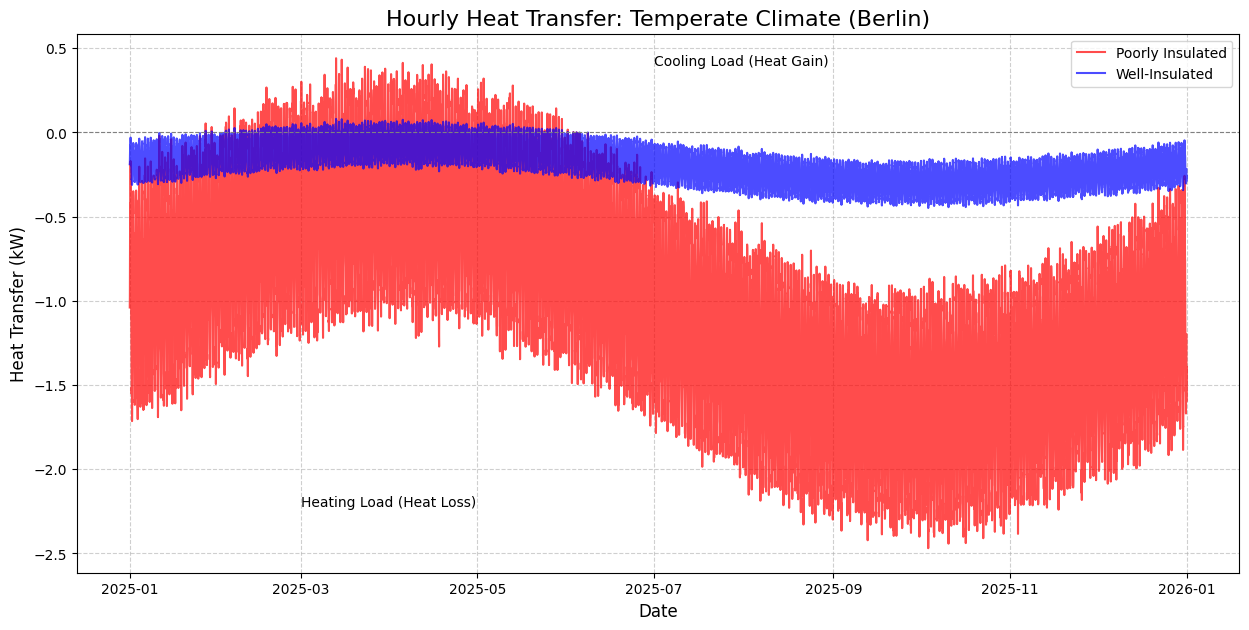

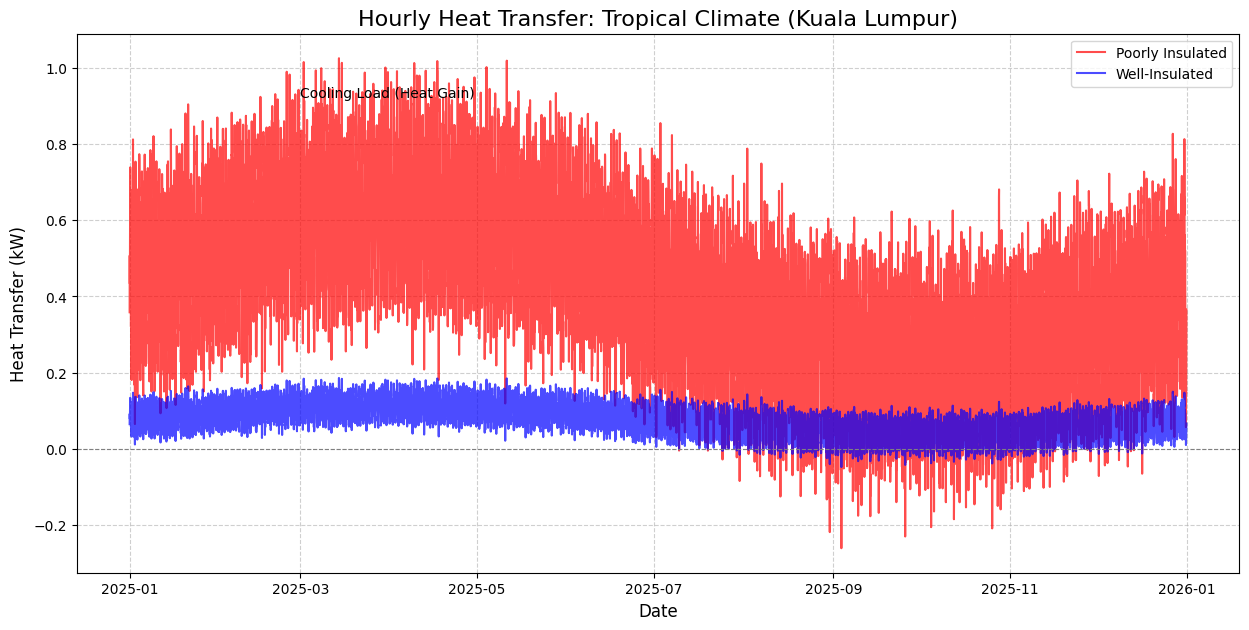

In [12]:
# ## Step 5: Visualizing


# Plot for Temperate Climate
plt.figure(figsize=(15, 7))
plt.plot(temperate_poor.index, temperate_poor['heat_transfer'] / 1000, label='Poorly Insulated', color='red', alpha=0.7)
plt.plot(temperate_good.index, temperate_good['heat_transfer'] / 1000, label='Well-Insulated', color='blue', alpha=0.7)
plt.title('Hourly Heat Transfer: Temperate Climate (Berlin)', fontsize=16)
plt.ylabel('Heat Transfer (kW)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# Place heating load text relative to the minimum y-value
y_min = temperate_poor['heat_transfer'].min() / 1000
plt.text(pd.Timestamp('2025-03-01'), y_min * 0.9, 'Heating Load (Heat Loss)', color='black', fontsize=10)
# Place cooling load text relative to the maximum y-value
y_max = temperate_poor['heat_transfer'].max() / 1000
plt.text(pd.Timestamp('2025-07-01'), y_max * 0.9, 'Cooling Load (Heat Gain)', color='black', fontsize=10)
plt.show()

# Plot for Tropical Climate
plt.figure(figsize=(15, 7))
plt.plot(tropical_poor.index, tropical_poor['heat_transfer'] / 1000, label='Poorly Insulated', color='red', alpha=0.7)
plt.plot(tropical_good.index, tropical_good['heat_transfer'] / 1000, label='Well-Insulated', color='blue', alpha=0.7)
plt.title('Hourly Heat Transfer: Tropical Climate (Kuala Lumpur)', fontsize=16)
plt.ylabel('Heat Transfer (kW)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# Place text relative to the maximum y-value
y_max = tropical_poor['heat_transfer'].max() / 1000
plt.text(pd.Timestamp('2025-03-01'), y_max * 0.9, 'Cooling Load (Heat Gain)', color='black', fontsize=10)
plt.show()

In [13]:
# ## Step 6: Quantifying the Savings
#

# Calculate total energy (kWh)
# Only consider heating (negative Q) or cooling (positive Q) loads.
# Assume heating costs are 0.25 €/kWh and cooling costs are 0.30 €/kWh (cooling is typically more expensive).
heating_cost_per_kwh = 0.25
cooling_cost_per_kwh = 0.30

def calculate_annual_cost(df, heating_cost, cooling_cost):
    """Calculates the total annual energy cost."""
    heating_energy_kwh = df[df['heat_transfer'] < 0]['heat_transfer'].sum() / 1000
    cooling_energy_kwh = df[df['heat_transfer'] > 0]['heat_transfer'].sum() / 1000
    
    heating_cost_total = abs(heating_energy_kwh) * heating_cost
    cooling_cost_total = abs(cooling_energy_kwh) * cooling_cost
    
    return heating_cost_total, cooling_cost_total, heating_energy_kwh, cooling_energy_kwh

# Temperate Climate
h_cost_poor_temp, c_cost_poor_temp, h_energy_poor_temp, c_energy_poor_temp = calculate_annual_cost(temperate_poor, heating_cost_per_kwh, cooling_cost_per_kwh)
h_cost_good_temp, c_cost_good_temp, h_energy_good_temp, c_energy_good_temp = calculate_annual_cost(temperate_good, heating_cost_per_kwh, cooling_cost_per_kwh)

# Tropical Climate
h_cost_poor_trop, c_cost_poor_trop, h_energy_poor_trop, c_energy_poor_trop = calculate_annual_cost(tropical_poor, heating_cost_per_kwh, cooling_cost_per_kwh)
h_cost_good_trop, c_cost_good_trop, h_energy_good_trop, c_energy_good_trop = calculate_annual_cost(tropical_good, heating_cost_per_kwh, cooling_cost_per_kwh)

# Print the results
print("\n--- Annual Energy Costs ---")
print(f"Temperate Climate (Poor Insulation): €{h_cost_poor_temp + c_cost_poor_temp:.2f}")
print(f"Temperate Climate (Good Insulation): €{h_cost_good_temp + c_cost_good_temp:.2f}")
print(f"Savings in Temperate Climate: €{(h_cost_poor_temp + c_cost_poor_temp) - (h_cost_good_temp + c_cost_good_temp):.2f}")

print("\n")

print(f"Tropical Climate (Poor Insulation): €{c_cost_poor_trop:.2f}")
print(f"Tropical Climate (Good Insulation): €{c_cost_good_trop:.2f}")
print(f"Savings in Tropical Climate: €{c_cost_poor_trop - c_cost_good_trop:.2f}")



--- Annual Energy Costs ---
Temperate Climate (Poor Insulation): €2277.23
Temperate Climate (Good Insulation): €414.04
Savings in Temperate Climate: €1863.19


Tropical Climate (Poor Insulation): €1115.65
Tropical Climate (Good Insulation): €202.85
Savings in Tropical Climate: €912.81
